#t-Distributed Stochastic Neighbor Embedding (t-SNE)
Los métodos de reducción de dimensión usados para visualización llevan un conjunto de datos en un espacio alta dimensión $\mathcal{X} = \{x_i, ... , x_n\}$ a uno de 2 o 3 dimensiones $\mathcal{Y} = \{y_i, ... , y_n\}$. Los métodos lineales clásicos, son muy buenos manteniendo lejos los puntos que están lejos, pero no son tan buenos manteniendo las estructuras locales. 

Han surgido varios métodos no lineales que intentan preservar mejor la estructura local, sin descuidar la global. Entre ellos, está SNE.
## Stochastic Neighbor Embedding (SNE)
Se basa en representar la similaridad entre cada par de puntos mediante probabilidades condicionales estimadas a partir de las distancias euclidianas entre ellos, tanto en el espacio original como en el espacio latente, y luego minimizando la divergencia de Kullback-Leibler de las probabilidades en los dos espacios.

La similaridad del punto $x_j$ al punto $x_i$ es la probabilidad condicional $p_
{j|i}$ que $x_i$ escogiera a $x_j$ como su vecino si esta elección fuera según una densidad de probabilidad normal centrada en $x_i$. Esta probabilidad está dada por:
$$
p_{j|i} = \frac{\exp{(-||x_i-x_j||^2/2\sigma_i^2)}}{\sum_{k\neq i} \exp{(-||x_i-x_k||^2/2\sigma_i^2)}}
$$

Las varianzas $\sigma_i$ pueden ser distintas para cada $x_i$, y por lo general no se tiene que un valor sea óptimo para todos los puntos.

La perplejidad es una medida de qué tan bien una distribución de probabilidad predice una muestra. En este caso se fija un valor de perplejidad y se encuentran las varianzas cuyas distribuciones mejor se ajustan a dicho valor.
$$
Perp(P_i) = 2^{H(P_i)}
$$
donde $H(P_i)$ es la entropía de Shannon de $P_i$ dada por
$$
H(P_i) = -\sum_j p_{j|i} \log_2 p_{j|i}
$$
Ya que esta medida tiene un comportamiento monótono en función de la varianza, se usa una búsqueda binaria para hallar el valor de esta última en cada caso.

Se asigna un valor inicial a los puntos $y_i$ en el espacio latente, correspondientes a cada $x_i$, y de manera análoga se calculan las probabilidades condicionales
$$
q_{j|i} = \frac{\exp{(-||y_i-y_j||^2)}}{\sum_{k\neq i} \exp{(-||y_i-y_k||^2)}}
$$
pero a diferencia del caso anterior se deja un valor de varianza fijo.

Además, se fijan $p_{i|i}=0$ y $q_{i|i}=0$, pues solo son de interés las similaridades entre pares de puntos distintos.

La divergencia de Kullback-Leibler da razón de qué tan buena representación de $p_{j|i}$ es $q_{j|i}$. SNE minimiza la suma de esta divergencia sobre todos los puntos usando gradiente descendiente. Es decir, la función de costo $C$ está dada por
$$
C = \sum_i KL(P_i||Q_i) = \sum_i \sum_j p_{j|i} \log \frac{p_{j|i}}{q_{j|i}}
$$
 y se minimiza usando el gradiente 

$$
\frac{\partial C}{\partial y_i} = 2 \sum_j (p_{j|i} - q_{j|i} + p_{i|j} - q_{i|j})(y_i - y_j)
$$

Para acelerar la optimización y evitar mínimos locales, se puede considerar además un término de _momentum_, quedando la actualización de los puntos en el espacio latente dada por

$$
\mathcal{Y}^{(t)} = \mathcal{Y}^{(t-1)} + \eta  \frac{\partial C}{\partial y_i} + \alpha(t) \left(\mathcal{Y}^{(t-1)} - \mathcal{Y}^{(t-2)}\right)
$$

con $\eta$ la tasa de aprendizaje y $\alpha (t)$ el _momentum_ en la iteración $t$.

## t-SNE
t-SNE se deriva a partir de SNE, con algunas modificaciones:
* Un problema de SNE es el _crowding problem_: los puntos en regiones muy densas en el espacio original de alta dimensión, al ser representadas en un espacio de menor dimensión tratando de preservar las distancias, quedan demasiado cerca por lo que no se aprecian adecuadamente las estructuras locales. En t-SNE esto se ataca usando una distribución t de Student con un grado de libertad para el espacio latente, la cual contribuye a este problema al tener colas más gruesas. De esta manera, para este caso se tiene:
$$
q_{ij} = \frac{(1+||y_i-y_j||^2)^{-1}}{\sum_{k\neq l} (1+||y_k-y_l||^2)^{-1}}
$$
* La función de costo en SNE es muy compleja. En t-SNE se usan similaridades simétricas para hacer más rápida la optimización. Para ello, se usa como similaridad en el espacio original
$$
p_{ij} = \frac{p_{i|j} + p_{j|i}}{2}
$$
Y entonces el gradiente queda 
$$
\frac{\partial C}{\partial y_i} = 4\sum_j (p_{ij} - q_{ij})(y_i - y_j)(1+||y_i-y_j||^2)^{-1}
$$

Estos cambios, hacen que en general se preserven de mejor manera las estructuras del espacio original en el espacio latente, y además facilitan la optimización de la función de costo del método.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.datasets import make_swiss_roll
seed = 123 

In [3]:
sr, y = make_swiss_roll(10000, random_state=seed)

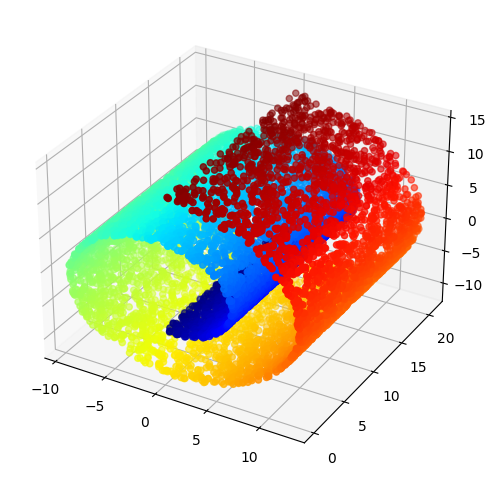

In [24]:
fig = fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(*sr.T, c=y, cmap='jet')

In [9]:
# la inicialización aleatoria arroja resultados distintos en distintas corridas
modelos_random = []
for i in range(3):
  tsne = TSNE(init='random')
  modelos_random.append(tsne.fit_transform(sr))

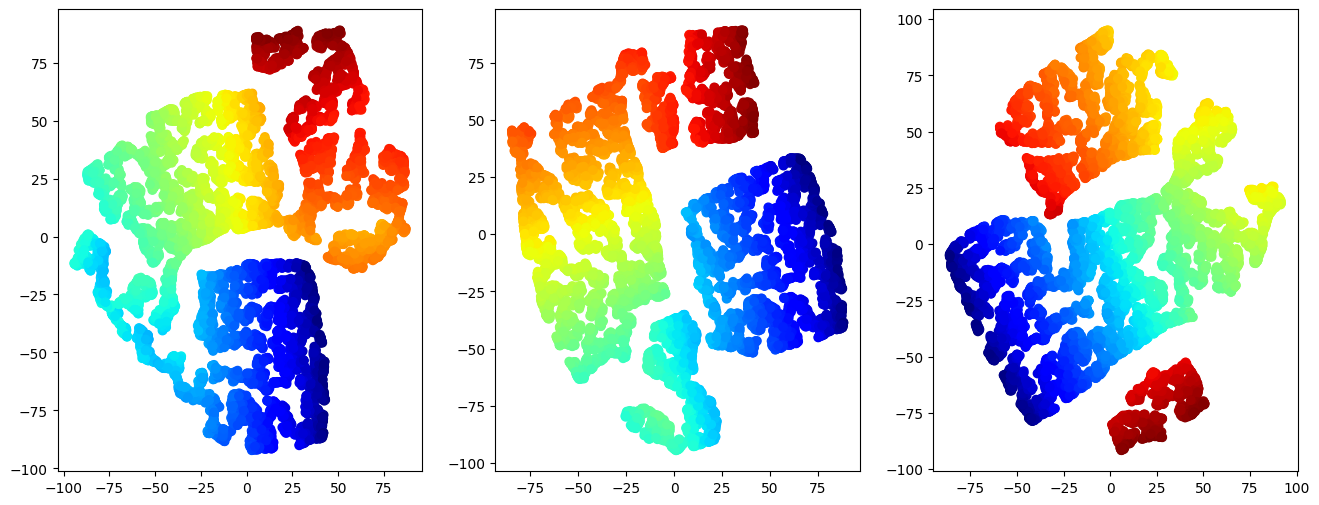

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
for i, ax in enumerate(axs):
  sc = ax.scatter(*modelos_random[i].T, c=y, cmap='jet')

In [17]:
modelos_pca = {}
for perp in (5, 30, 50):
  tsne = TSNE(init='pca', perplexity=perp) # por defecto se inicializa con pca
  modelos_pca[perp] = (tsne.fit_transform(sr))

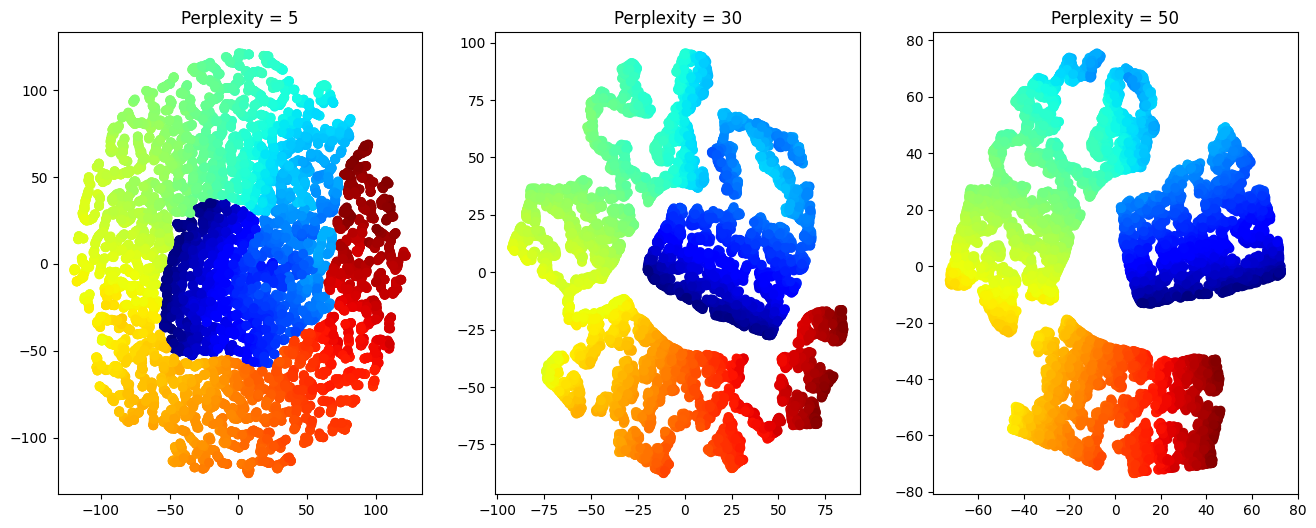

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
for i, ax in enumerate(axs):
  perp, X = list(modelos_pca.items())[i]
  sc = ax.scatter(*X.T, c=y, cmap='jet')
  ax.set_title(f'Perplexity = {perp}')

##Housing dataset

In [25]:
#cargar datos desde drive acceso libre
FILEID = "1vrk5heTgxMBZagbw62SSVSWvfrW--Jgz"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O codigos.zip && rm -rf /tmp/cookies.txt
!unzip codigos.zip
!dir

--2023-05-25 23:10:55--  https://docs.google.com/uc?export=download&confirm=t&id=1vrk5heTgxMBZagbw62SSVSWvfrW--Jgz
Resolving docs.google.com (docs.google.com)... 142.251.16.138, 142.251.16.101, 142.251.16.113, ...
Connecting to docs.google.com (docs.google.com)|142.251.16.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-0s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6678pb9impno02i6n57r6ho0ddrp489i/1685056275000/09173029842254050324/*/1vrk5heTgxMBZagbw62SSVSWvfrW--Jgz?e=download&uuid=45ded7b4-1681-49e4-9371-ed72c46e2a56 [following]
--2023-05-25 23:11:24--  https://doc-0g-0s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6678pb9impno02i6n57r6ho0ddrp489i/1685056275000/09173029842254050324/*/1vrk5heTgxMBZagbw62SSVSWvfrW--Jgz?e=download&uuid=45ded7b4-1681-49e4-9371-ed72c46e2a56
Resolving doc-0g-0s-docs.googleusercontent.com (doc-0g-0s-docs.googleusercontent.com)... 172.253.62.132, 

In [27]:
housing = pd.read_csv('datasets/housing/housing.csv')
housing.drop(columns=['ocean_proximity'], inplace=True)

In [32]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

X_housing, y_housing = housing.iloc[:,:-1], housing.iloc[:, -1]
modelos_housing = {}
for perp in (5, 25, 50):
  pipe_housing = Pipeline([('imputer', SimpleImputer(strategy='median')),
                          ('scaler', StandardScaler()),
                          ('tsne', TSNE(perplexity=perp))])
  modelos_housing[perp] = pipe_housing.fit_transform(X_housing)

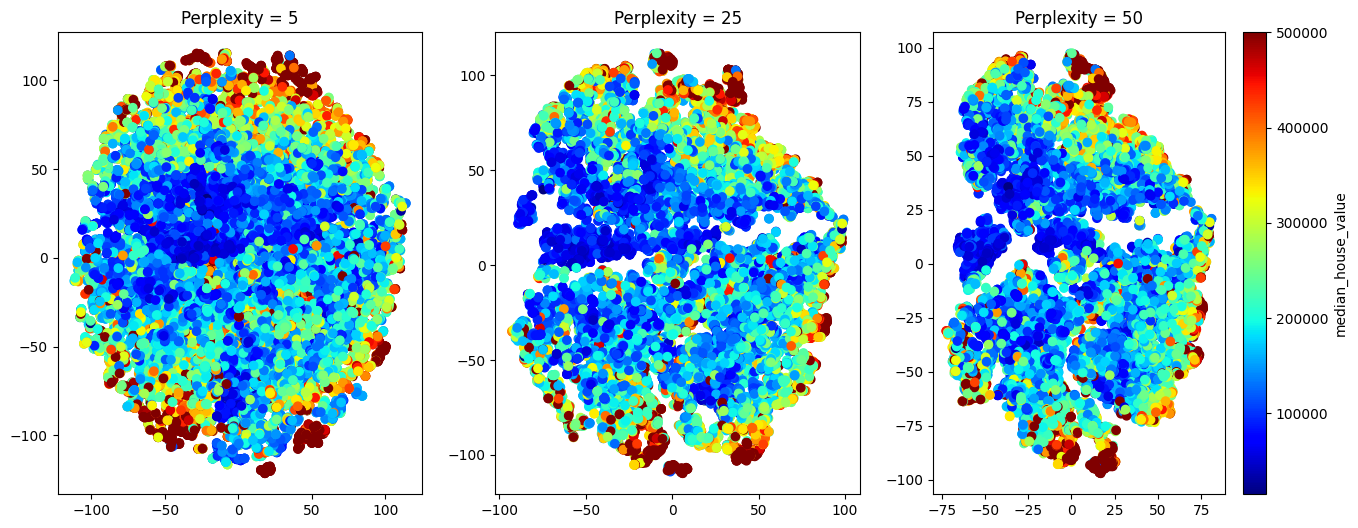

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
for i, ax in enumerate(axs):
  perp, X = list(modelos_housing.items())[i]
  sc = ax.scatter(*X.T, c=y_housing, cmap='jet')
  ax.set_title(f'Perplexity = {perp}')
plt.colorbar(sc, label='median_house_value')

In [39]:
fifa = pd.read_csv('datasets/data_fifa19.csv')
col_drop = ['Unnamed: 0', 'Name','ID','Photo','Flag', 'Club Logo','Loaned From',
            'Nationality','Club','Body Type','Position','Preferred Foot',
            'Work Rate','Real Face','Contract Valid Until', 'Joined']
fifa.drop(columns=col_drop, inplace=True)
X_fifa, y_fifa = fifa.iloc[:,:-1], fifa.iloc[:, -1]

 #codificar variables moneda
def code_euro(y):
    yc = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
        if y[i][-1]=='M': yc[i] = float(y[i][1:-1])*10**6 #buscar M y reemplazar 10^6
        elif y[i][-1]=='K': yc[i] = float(y[i][1:-1])*10**3 # buscar K y reemplazar por 10^3
        else: yc[i] = float(y[i][1:])
    return yc 

#codificar estadísticas
def code_stats(y):
    yc = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
        if y.iloc[i].find("+") > -1: # encontrar signo + en str y casteo a flotante
            yc[i] = float(y.iloc[i][:y.iloc[i].find("+")])+float(y.iloc[i][y.iloc[i].find("+")+1:])
        else: yc[i] = float(y.iloc[i])
    return yc 

imputer = SimpleImputer(strategy='most_frequent')
y_fifa = imputer.fit_transform(pd.DataFrame(y_fifa)).reshape(-1)
y_fifa = code_euro(y_fifa)

from sklearn.base import BaseEstimator, TransformerMixin #objetos básicos para herencia de clase

class mypre_fifa(BaseEstimator,TransformerMixin):
    #inicializacion de clase y varaibles
    def __init__(self, col_euro,col_stats): #constructor clase
        self.col_euro = col_euro #lista atributos tipo moneda
        self.col_stats = col_stats #lista atributos tipo estadistica

    def fit(self,X, *_):#función de ajuste -> *_ para indicar que puede recibir más entradas en el pipeline
        Xi = X.copy() #copiar dataset para no reemplazar original
        self.imputer_num = SimpleImputer(strategy="most_frequent") #crear imputador tipo moda
        self.a = Xi.columns[np.sum(Xi.isna())> 0] #encontrar columnas con datos faltantes
        self.imputer_num.fit(Xi[self.a]) # ajustar imputador
        Xi[self.a] = self.imputer_num.transform(Xi[self.a]) #evaluar datos con el imputador
        
        for i in self.col_euro: #codificar tipo moneda
            Xi[i] = code_euro(np.array(Xi[i]))
        
        for i in self.col_stats: #codificar datos estadisticos
            Xi[i] = code_stats(Xi[i])
        
        #height, wieght corregir formato
        Xi['Height'].replace(regex=["'"], value='.',inplace=True) #reemplaza unidad ' con .       
        for i in Xi.index:
            Xi.loc[i,'Weight'] = float(Xi.loc[i,'Weight'][:-3])#elimnar unidades 
            Xi.loc[i,'Height'] = float(Xi.loc[i,'Height'])#eliminar unidades
        
        Xi['Height'] = Xi['Height'].astype('float64')
        Xi['Weight'] = Xi['Weight'].astype('float64')#asegurar formato flotante
            
        return self    

    def transform(self, X, *_):#funcion transformador-> pensando en datos nuevos
        Xi = X.copy()
        Xi[self.a] = self.imputer_num.transform(Xi[self.a])
        
        for i in self.col_euro:
            Xi[i] = code_euro(np.array(Xi[i]))
        for i in self.col_stats:
            Xi[i] = code_stats(Xi[i])
        
                #height, wieght
        Xi['Height'].replace(regex=["'"], value='.',inplace=True)        
        for i in Xi.index:
            Xi.loc[i,'Weight'] = float(Xi.loc[i,'Weight'][:-3])
            Xi.loc[i,'Height'] = float(Xi.loc[i,'Height'])
        
        Xi['Height'] = Xi['Height'].astype('float64')
        Xi['Weight'] = Xi['Weight'].astype('float64')
               
        return Xi
    
    def fit_transform(self,X,*_):#ajustar y transformar en cascada
        self.fit(X)
        return self.transform(X)

col_euro = ['Value','Wage'] #variables tipo moneda
col_stats = ['LS','ST','RS','LW','LF','CF','RF','RW','LAM',
             'CAM','RAM','LM','LCM','CM','RCM','RM','LWB',
             'LDM','CDM','RDM','RWB','LB','LCB','CB','RCB','RB']#variables tipo mejora jugadores
steps = [('preproceso',mypre_fifa(col_euro=col_euro, col_stats=col_stats)), 
         ('scaler', StandardScaler())]
pipe_fifa = Pipeline(steps=steps)
X_fifa = pipe_fifa.fit_transform(X_fifa)

In [40]:
modelos_fifa = {}
for perp in (5, 25, 50):
  tsne = TSNE(perplexity=perp)
  modelos_fifa[perp] = tsne.fit_transform(X_fifa)

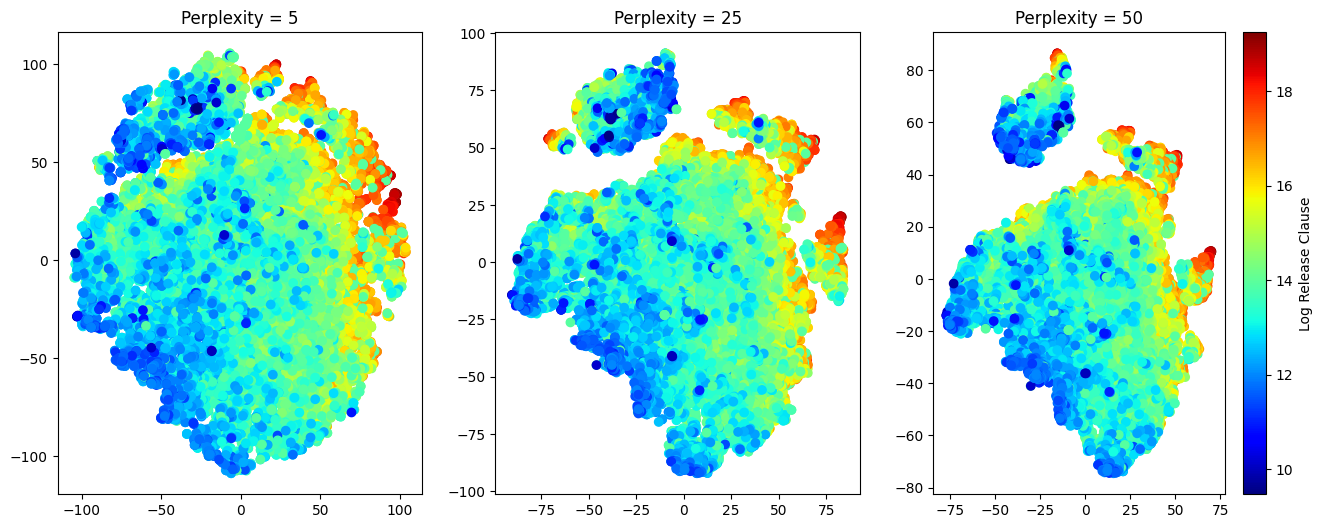

In [47]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
for i, ax in enumerate(axs):
  perp, X = list(modelos_fifa.items())[i]
  sc = ax.scatter(*X.T, c=np.log(y_fifa), cmap='jet')
  ax.set_title(f'Perplexity = {perp}')
plt.colorbar(sc, label='Log Release Clause')